# Chapter 14 | Convolutional Neural Networks (CNNs)
They emerged from the study of the brain's visual cortex and they represent the state of art in image recognition, but they are also implemented in other tasks, such as voice recognition and natural language processing.

## The Visual Cortex
One of the main insights drawn from past experiments is that many neurons in the visual cortex have **small local receptive field**, so they react only to visual stimuli located in a limited region. The overlap of the receptive fields of different neurons take to the whole visual field.

Moreover, some neurons react only to images of horizontal lines, some only to **different orientation** ones, even if they share the same receptive field.

Furthermore, some neurons have larger receptive fields and they react to more complex patterns, that are combinations of the lower-level patterns: this took to the idea that higher-level neurons are based on the outputs of neighboring lower-level neurons.

These discoveries inspires the neocognitron, which gradually evolved into the nowadays **Convolutional Neural Networks (CNNs)**; these introduces 2 new building blocks:
- **Convolutional Layers**;
- **Pooling Layers**.

## Convolutional Layers

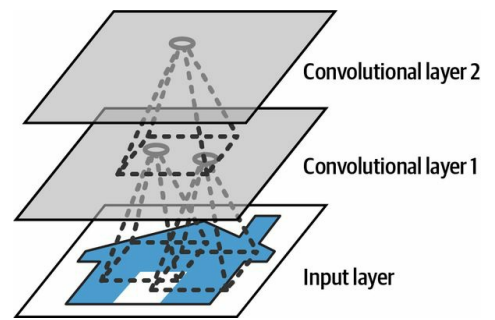

It is the most important block of CNNs; the main difference with a Fully Connected Layer is that neurons in the first convolutional layer are **not connected** to every single pixel in the input image, but only to pixels in their **receptive fields** (in a fully connected layer with input of 100x100 pixels = 10,000 pixels, we would have 10,000 neurons just in the first layer, which need to be connected to each of the neurons of the next layer, taking to lot of connections and weights).

This **locality** allows the network to focus on small low-level features in the first layer, then assemble them into larger higher-level features in the next layer, and so on.

Suppose having a receptive field with dimensions $f_h \times f_w$: a neuron located in row $i$ and column $j$ of a given layer will be connected to the outputs of the neurons in the previous layer located in rows $i$ to $i + f_h-1$ and columns $j$ to $j + f_w -1$. 

Considering those "$-1$" would take to decrease the dimension of data in each layer, it is common to add zeros around the input; this technique is called **zero padding**.

Another technique allowing to connect large input layer to smaller layer is called **stride**, which involve to space out the receptive fields, reducing the computational complexity.

### Filters (or Kernels)
The set of weights big as the size of the receptive fields form the so called **filter (or convolution kernel, or kernel)**.

Based on the weights of this filter, neurons using them will focus on some aspects of their receptive field and ignore others.

For example, if all neurons in a layer use a filter with 1s in central column and 0s anywhere else, this will take to ignore everything in their receptive field except for the central vertical line (Left Image on the figure below), while using a filter with 1s in central row and 0s anywhere else will take to ignore everything except for the central horizontal line (Right Image on the figure below).

The output of one Convolutional Layer is called a **Feature Map**. 

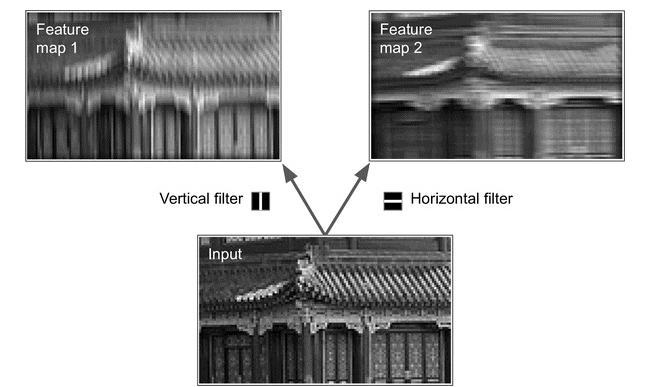

(NOTE: the convolutional layer will **automatically learn** the most useful filters for its task)

### Feature Maps
As we saw above, the output of one Convolutional Layer is called the Feature Map; in the image above we represented it with a 2D layer (i.e., an image), but in reality, a Convolutional Layer will use **multiple filters** (we need to decide how many), so it output several feature maps, one per filter, taking to a 3D layer.

The convolutional layer has **one neuron per pixel in each feature map** and all neurons in a given feature map share the same parameters (i.e., same kernel and bias); neurons in different feature maps use different parameters.

(NOTE: sharing same parameters in one feature map drastically reduces the number of parameters; the idea is that once the CNN has learnt to recognize a pattern in one location, it can recognize it in any other location, while this didn't happen with fully connected NN)

We can express the **output of a neuron in a convolutional layer** as:
$$z_{i,j,k} = b_k + \sum_{u=0}^{f_h -1} \sum_{v=0}^{f_w -1} \sum_{k'=0}^{f'_n -1}x_{i', j', k'} \cdot w_{u,v,k',k}$$
with:
$$i' = i \cdot s_h + u$$ 



$$j' = j \cdot s_w + v$$

where:
- $z_{i,j,k}$ is **output of neuron** located in row $i$, column $j$, feature map $k$ (of layer $l$);
- $b_k$ is **bias term** for feature map $k$ (of layer $l$); think of this as knob tweaking the brightness of the feature map;
- $x_{i', j', k'}$ os **output of neuron** located in row $i'$, column $j'$, feature map $k'$ (of layer $l-1$); if $l-1$ is the input layer, then $k'$ is a channel;
- $w_{u,v,k',k}$ is the **connection weight** between any neuron in feature map $k$ (of the layer $l$) and its input located at row $u$, column $v$, feature map $k'$.

### Implementing Convolutional Layer with Keras
Let's load some sample images:

In [1]:
import tensorflow as tf

2025-07-30 17:01:42.777820: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753887702.796520    6925 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753887702.801996    6925 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753887702.817858    6925 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753887702.817891    6925 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1753887702.817893    6925 computation_placer.cc:177] computation placer alr

In [3]:
from sklearn.datasets import load_sample_images

images = load_sample_images()['images']
images = tf.keras.layers.CenterCrop(height = 70, width = 120)(images) # Resize to Guarantee same Dimensions (70 x 120)
images = tf.keras.layers.Rescaling(scale = 1/255)(images) # Normalization to get all pixels ranging from 0 to 1

I0000 00:00:1753887979.036613    6925 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2230 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650 SUPER, pci bus id: 0000:29:00.0, compute capability: 7.5


Let's look at the shape:

In [2]:
images.shape

TensorShape([2, 70, 120, 3])

(2 sample images, 70x80 pixels, 3 channels)

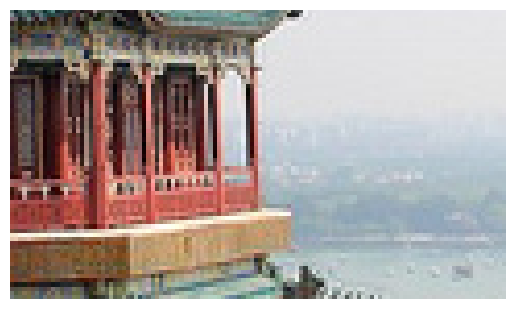

In [4]:
import matplotlib.pyplot as plt

plt.imshow(images[0])
plt.axis('off')
plt.show()

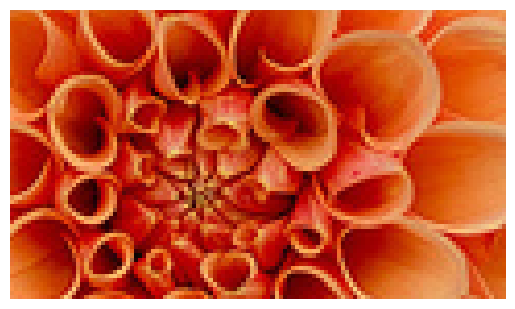

In [4]:
plt.imshow(images[1])
plt.axis('off')
plt.show()

Even if 'images' has 4 dimensions, in reality it has 2 spatial dimensions (height and width); let's implement a 2D Convolutional Layer with 32 Filters, each of size 7x7:

In [5]:
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = 7)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 64, 114, 32])

We can see 2 main differences:
- both Height and Width shrunk by 6 pixels (this is because we didn't add any 0-padding so we lose pixels on the sides; being the kernel 7x7, we lose 6 pixels horizontally and 6 vertically);
- we went from 3 channels (RGB) to 32 channels (the feature maps): instead of having the intensity of red, green and blue at each location, we now have the intensity of each feature map at each location.

By default, the parameter is *padding = "valid"*, which means no 0-padding (the receptive field of each neuron must lie within *valid* positions, so no out of bound);

if we want 0-padding, we can put the parameter *padding = "same"* (which means that, with stride s = 1, feature maps end up with *same* size as input).

The formula to get the output size is:

$$ o = round\_down(\frac{i +2p -f}{s}) + 1$$

Let's try with 0-padding:

In [6]:
conv_layer = tf.keras.layers.Conv2D(filters = 32, kernel_size = 7, padding = 'same')
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 70, 120, 32])

We can access the layer parameter (kernels and biases) in 2 ways:
- as TF variables:

In [7]:
conv_layer.weights

[<Variable path=conv2d_1/kernel, shape=(7, 7, 3, 32), dtype=float32, value=[[[[-5.07788956e-02 -1.81158483e-02 -1.77524500e-02 ...  4.38909829e-02
     -8.70883465e-03 -8.56657326e-03]
    [-2.10216418e-02  5.63775524e-02  1.27772763e-02 ... -1.67805776e-02
     -3.32651660e-03  2.03185901e-03]
    [ 5.27604073e-02  1.65033564e-02 -2.39940956e-02 ... -9.50660184e-03
      6.09412044e-03 -2.31505223e-02]]
 
   [[-4.56591994e-02 -1.28202289e-02  1.80725679e-02 ... -2.68244408e-02
     -2.94505209e-02  1.01848692e-02]
    [-1.88770369e-02  3.04095075e-02  5.42390347e-03 ... -5.47614247e-02
     -2.75014713e-03  3.97446752e-03]
    [ 5.37887067e-02 -4.09809574e-02  2.27448493e-02 ...  3.61806303e-02
     -2.27760971e-02 -3.27292010e-02]]
 
   [[-6.72272220e-03  5.35563752e-02  5.55800125e-02 ...  1.87220424e-02
     -5.00777960e-02 -1.70888342e-02]
    [ 2.79143676e-02  4.71251458e-03 -1.60683654e-02 ...  1.97289884e-03
     -5.41397072e-02  4.86671925e-02]
    [ 9.08359885e-04  8.00450146

- as np arrays:

In [8]:
conv_layer.get_weights()

[array([[[[-5.07788956e-02, -1.81158483e-02, -1.77524500e-02, ...,
            4.38909829e-02, -8.70883465e-03, -8.56657326e-03],
          [-2.10216418e-02,  5.63775524e-02,  1.27772763e-02, ...,
           -1.67805776e-02, -3.32651660e-03,  2.03185901e-03],
          [ 5.27604073e-02,  1.65033564e-02, -2.39940956e-02, ...,
           -9.50660184e-03,  6.09412044e-03, -2.31505223e-02]],
 
         [[-4.56591994e-02, -1.28202289e-02,  1.80725679e-02, ...,
           -2.68244408e-02, -2.94505209e-02,  1.01848692e-02],
          [-1.88770369e-02,  3.04095075e-02,  5.42390347e-03, ...,
           -5.47614247e-02, -2.75014713e-03,  3.97446752e-03],
          [ 5.37887067e-02, -4.09809574e-02,  2.27448493e-02, ...,
            3.61806303e-02, -2.27760971e-02, -3.27292010e-02]],
 
         [[-6.72272220e-03,  5.35563752e-02,  5.55800125e-02, ...,
            1.87220424e-02, -5.00777960e-02, -1.70888342e-02],
          [ 2.79143676e-02,  4.71251458e-03, -1.60683654e-02, ...,
            1.972

In [9]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

(kernel_height, kernel_width, input_channels, output_channels)

In [10]:
biases.shape

(32,)

Lastly, we generally want to specify an Activation Function (such as ReLU), for the same reason as for Dense layers, in which we wanted to add Non-Linearity.

As we see, CNN has quite few hyperparameters:
- number of filters;
- size of filters;
- padding;
- strides;
- activation function;
- initializer of filter;
- ...
  
We can still use cross-validation, but it's very time consuming, so we'll discuss about common CNN architectures to get some working best hyperparameter values.

## Pooling Layer
The goal of the pooling layer is to **subsample (shrink)** the input image in order to reduce computational load, memory usage and number of parameters (reducing risk of overfitting).

Just as in the convolutional layer, each neuron in a pooling layer is just locally connected to a limited number of neurons of the previous layer in its receptive field (so we need to define size, stride, padding), but this time, we don't have any weights: the pooling neurons use an **Aggregation Function** (such as max or mean) to aggregate the inputs.

For example, by using **Max-Pooling** (which is indeed the most common one), only the max input value in each receptive field makes it to the next layer, while the other are dropped:

(Example below is Max-Pooling with a 2x2 Pooling Kernel, stride of 2 and no padding; the stride of 2 makes the output image have half height and width of input image, rounded down since no padding)

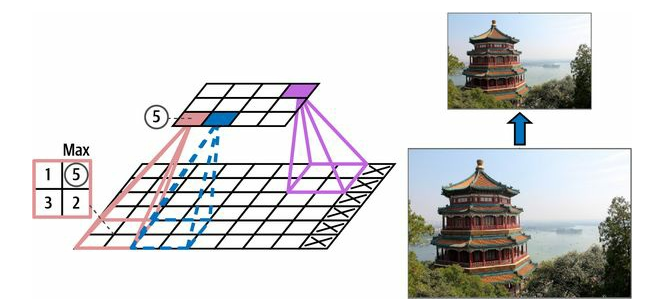

Max-Pooling introduces some level of **invariance to small translations**, which is a good advantage in tasks life classification, but may also be a downside in other tasks like semantic segmentation (the goal here is **equivariance**, not invariance, cause a small change to inputs may lead to a corresponding change in the output): 

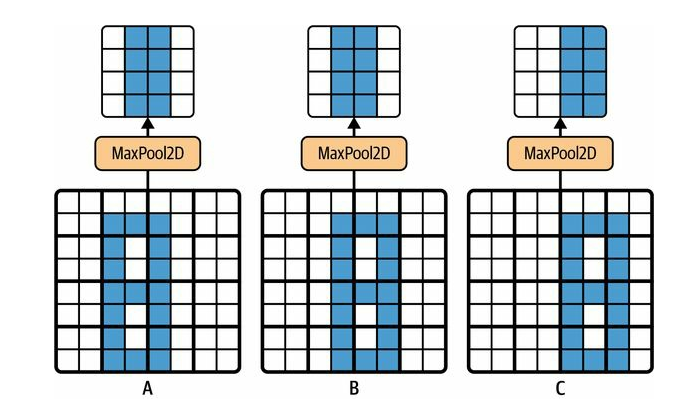

We can sum the downsides of max-pooling by highlighting its **destructive** effect.

### Implementing Pooling Layers with Keras
We will implement a MaxPooling 2D layer with a 2x2 Pooling Kernel:

(NOTE: stride is by default equal to the kernel size, so 2, while padding is by default 'valid', so no padding)

In [11]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

(NOTE: we can implement an Average Polling layer with AvgPool2D, but keep in mind that MaxPooling geberally performs better)

Considering MaxPooling add invariance to feature, by applying pooling along the depth dimension (instead of the spatial dimensions) allows the CNN to learn to be invariant to various features (rotation, thickness, brighthness, skew, color...); still, this practice is not that common.

Other than MaxPooling and AvgPooling, another modern approach is **Global Average Pooling**, which computes the mean of each entire feature map (it is like using AvgPooling with a Pooling Kernel with same size as input), taking to a single number output per feature map (it is extremely destructive, but can be useful just before the output layer):

In [13]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

For example, we can apply this to the input images and get the mean intensity of red, green and blue:

In [14]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

## CNN Architectures
Now that we know all the building blocks, let's look at the whole architecture of a CNN.

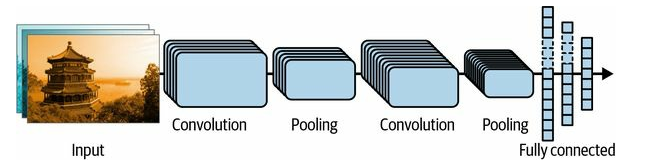


CNNs usually involve:
- Input Layer;
- a series of Convolutional Layers, Activation Function (generally ReLU) and Pooling Layers (generally MaxPooling);
- a Fully Connected NN (compose of fully connected layers with ReLUs and final output layer for predictions, usually softmax).

The more we progress in the "Convolutional part" of the network (Convolutional Layers, ReLU, Pooling), the more the image gets smaller, but deeper (i.e., more feature maps).

(**TIP**: instead of using larger kernel, use more layers with smaller kernels; for example instead of a convolutional layer with 5x5 kernel, use two layers with 3x3 kernels: this will take to fewer parameters, fewer computations and usually better performance; 
**EXCEPTION**: in the first convolutional layer the kernel is typically larger, such as 5x5 with stride of 2, in order to reduce spacial dimension without lossing too much information and with not that much computations, considering at the start we only have 3 channels in general)

## Full CNN Implementation for MNIST Challenge

In [5]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')

model = tf.keras.Sequential([
    DefaultConv2D(filters = 64, kernel_size=7, input_shape = [28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 128),
    DefaultConv2D(filters = 128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters = 256),
    DefaultConv2D(filters = 256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units = 128, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units = 10, activation = 'softmax')
    ])

/home/essskevin/tf-env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(functools.partial() helped us create a Conv2D object but with different default arguments, to avoid rewriting it each time)

The Sequential model has:
- Convolutional Layer with 64 7x7 filters, default stride of 1 (cause images are not that large) and input shape as the MNIST images (28x28 with a single channel);
- Max Pooling Layer with default pool size of 2 (so each spatial dimension is divided by a factor of 2);
- 2 Convolutional Layer + 1 MaxPooling (we repeat this whole structure 2 times);

    (NOTE: for larger images, we could repeat this structure more times; number of times is an hyperparameter we can tune)

    (NOTE: we double the output layer each time, cause with pool size of 2, each spatial dimension is divided by a factor of 2, so we're not worried about the number of parameters to explode)
- Flatten Layer (Fully Connected Layer expects a 1D array of features for each instance)
- Fully Connected Layer with 2 hidden dense layers, 2 dropout layers with dropout rate of 50 % (this reduces overfitting) and 1 dense output layer (output layers has 10 units cause it's a classification task with 10 classes).

(if MNIST dataset images come in different shape, we may need to use np.reshape() or to add a Reshape Layer as first layer) 

In [6]:
from functools import partial

tf.random.set_seed(42)

# Load & preprocess MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0
x_train = x_train[..., tf.newaxis]   # (60000, 28, 28, 1)
x_test  = x_test[..., tf.newaxis]    # (10000, 28, 28, 1)

# Define model (your architecture)
DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    kernel_size=3,
    padding="same",
    activation="relu",
    kernel_initializer="he_normal"
)

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

# Optional: Early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=3,
        restore_best_weights=True
    )
]

# Train
history = model.fit(
    x_train, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=2
)

# Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\nTest accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

# Quick predictions demo
probs = model.predict(x_test[:5])
preds = tf.argmax(probs, axis=1).numpy()
print("First 5 predictions:", preds)
print("True labels        :", y_test[:5])

# Save model
model.save("mnist_cnn.h5")
print("Model saved to mnist_cnn.h5")


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 64)     │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 14, 14, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,413,834 (5.39 MB)

 Trainable params: 1,413,834 (5.39 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1753888012.895722    8242 service.cc:152] XLA service 0x719bec0028f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753888012.895756    8242 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1650 SUPER, Compute Capability 7.5
2025-07-30 17:06:52.959112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1753888013.291159    8242 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-30 17:06:54.275929: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[64,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,14,14]{3,2,1,0} %bitcast.8795, f32[128,64,3,3]{3,2,1,0} %bitcast.8061, f32[128]{0} %bitcast.8855), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

844/844 - 26s - 31ms/step - accuracy: 0.7187 - loss: 0.8075 - val_accuracy: 0.9847 - val_loss: 0.0625
Epoch 2/10
844/844 - 11s - 14ms/step - accuracy: 0.9334 - loss: 0.2348 - val_accuracy: 0.9895 - val_loss: 0.0468
Epoch 3/10
844/844 - 11s - 13ms/step - accuracy: 0.9610 - loss: 0.1493 - val_accuracy: 0.9883 - val_loss: 0.0535
Epoch 4/10
844/844 - 15s - 17ms/step - accuracy: 0.9709 - loss: 0.1174 - val_accuracy: 0.9925 - val_loss: 0.0384
Epoch 5/10
844/844 - 11s - 13ms/step - accuracy: 0.9781 - loss: 0.0918 - val_accuracy: 0.9903 - val_loss: 0.0420
Epoch 6/10
844/844 - 12s - 14ms/step - accuracy: 0.9826 - loss: 0.0713 - val_accuracy: 0.9887 - val_loss: 0.0516
Epoch 7/10
844/844 - 15s - 17ms/step - accuracy: 0.9837 - loss: 0.0632 - val_accuracy: 0.9925 - val_loss: 0.0516


2025-07-30 17:08:32.660592: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[32,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,14,14]{3,2,1,0} %bitcast.622, f32[128,64,3,3]{3,2,1,0} %bitcast.629, f32[128]{0} %bitcast.631), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_6_1/convolution" source_file="/home/essskevin/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-30 17:08:32.725079: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted


Test accuracy: 0.9917 | Test loss: 0.0415


2025-07-30 17:08:35.473959: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.16 = (f32[5,128,14,14]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,64,14,14]{3,2,1,0} %bitcast.312, f32[128,64,3,3]{3,2,1,0} %bitcast.319, f32[128]{0} %bitcast.321), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="sequential_1_1/conv2d_6_1/convolution" source_file="/home/essskevin/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-30 17:08:35.528911: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted p

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step


First 5 predictions: [7 2 1 0 4]
True labels        : [7 2 1 0 4]
Model saved to mnist_cnn.h5


## Most Famous CNN Architectures

### LeNet-5
The [LeNet-5](https://www.eecis.udel.edu/~shatkay/Course/papers/NetworksAndCNNClasifiersIntroVapnik95.pdf) is the most widely known CNN architecture. Created by Yann LeCun in 1998 and widely used for the MNIST challenge. 

The architecture is:

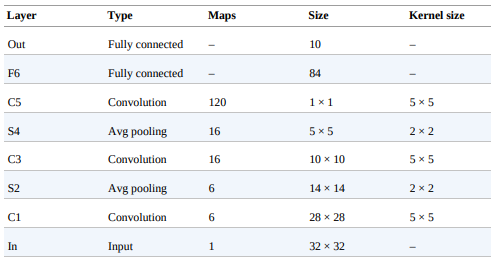

As we see, it is similar to our implementation above: a stack of Convolutional and Pooling Layers, followed by a Dense Network; the main difference is in the activation functions: today, ReLU is preferred to tanh and softmax to RBF (other minor differences don't matter much).

### AlexNet
The [AlexNet](https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) won the 2012 ILSVRC with large margin (top-five error rate of 17%, while the second best achieved 26%). It was developed by Alex Krizhevsky, Ilya Sustkever and Geoffre Hinton. The architecture is very similar to LeNet-5 (just **much larger and deeper**) and it was the first one to **stack Convolutional Layers directly** on top of one another (instead of stacking a Pooling Layer on top of each Convolutional one):

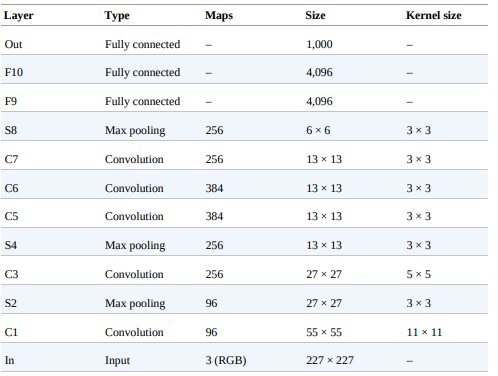

Considering the large amount of parameters, to reduce overfitting the authors used 2 **Regularization Techniques**:
- **Drop-Out** (Chapter 11 of this book) with 50% dropout rate during training to the outputs of layers F9 and F10;
- **Data Augmentation** by randomly shifting the training images (flipping, changing lightning...)

#### Data Augmentation
It is a **Regularization Technique (i.e., reduces overfitting)** used to **artificially increase size of training set** by generating **realistic variants** of each training istance (note how realistic means that humans should not be able to tell wheter the image was augmented or not), in order to increase tolerance to particular conditions of the picture. It can be used also to generate more samples of the **less frequent class** (in this case the technique is called **Syntethic Minority Oversampling Technique (SMOTE)**).

Examples of Data Augmentation are **shifting, rotating, resizing** the pictures (these techniques forces the model to be **more tolerant** to **variations in position**). This can be done in Keras with the **Keras's Data Augmentation Layers** (already introduced in Chapter 13 of this book), such as **RandomCrop, RandomRotation, etc.** 
Other examples rely on forcing the model to be **more tolerant** to **different lighting conditions**, by simply changing the images contrasts.

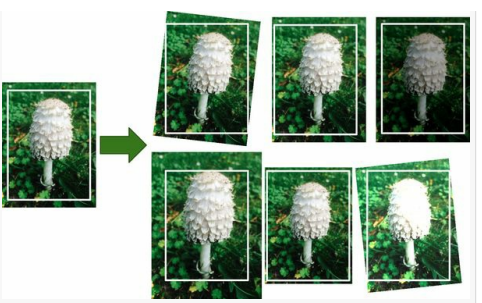

Another technique used in AlexNet is the so called **Local Response Normalization (LRN)**, a **Competitive Activation** step in which the **most strongly activated neurons** inhibit other neurons located at the same position in neighboring feature maps, incouraging different feature maps to **specialize**, pushing them apart and **forcing them to explore wider range of features**, **improving generalization** (this type of competitive activation has been observed in biological neurons and it is called **Lateral Inhibition**).

We can perform LRN with the equation:

$$b_i = \frac{a_i}{(k + \alpha \sum_{j = j_{low}}^{j_{high}}a_j^2)^\beta}$$

with:
- $j_{low} = max(0, i - \frac{r}{2})$;
- $j_{high} = min(i + \frac{r}{2}, f_n -1)$

where:
- $b_i$ is the **Normalized Output** of neuron located in feature map $i$, at some row $u$ and column $v$ (in this equation, we only consider neurons located at this row and column, so $u$ and $v$ are omitted);
- $a_i$ is the **Activation** of that neuron after ReLU step (just before Normalization);
- $k, \alpha, \beta, r$ are **hyperparameters** of the RLN ($k$ is called **bias**, $r$ is called **depth radius**);
- $f_n$ is **number of feature maps**.

For example, suppose to put $r = 2$ and to have a neuron with strong activation: it will inhibit the activation of the neurons located in the feature maps immediately above and immediately below its own feature map.

In AlexNet, $r = 5, \alpha = 0.0001, \beta = 0.75, k = 2$.

We can implement this step by using the tf.nn.local_response_normalization() method, which can be wrapped in a Lambda layer to be used in a Keras model.

[ZF Net](https://arxiv.org/abs/1311.2901), which won the 2013 ILSVRC, is essentialy AlexNet with few different hyperparameters.


### GoogLeNet
The [GoogLeNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html), developed by Christian Szegedy won the ILSVRC 2014, pushing the top-five error rate below 7%. This was reached primarily thanks to a much deeper network than previous, made possible by **subnetworks** called **inception modules**, which allow a much more efficient use of parameters (GoogLeNet has 10 times fewer parameters than AlexNet -> 6 million vs 60 million).

Let's look more in depth an **Inception Module**:

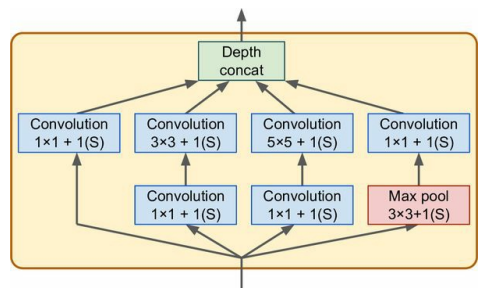

(The notation "$3\times3+1(S)$" means the layer used a $3\times3$ kernel, stride 1 and "same" (S) padding)

Note how:
- the input is fed to four different layers in parallel;
- the top convolutional layers use different kernel sizes (this allow to capture patterns at different scales);
- all layers use stride of 1 and "same" padding, allowing to get outputs with **same height and width** of the inputs, in order to be able to **concatenate all outputs** along the **depth dimension** in the final **Depth Concatenation Layer** (i.e., to stack the feature maps from all 4 layers). This last layer can be  implemented in Keras using Kera's **Concatenate Layer**, using the default "axis = 1".

Why the $1\times1$ kernels?

Altough they cannot capture spatial patterns, they can capture patterns **along the depth dimension** (i.e., across channels); moreover, they output fewer feature maps than their inputs, serving as **bottleneck layers** (i.e., they reduce dimensionality, cutting computational cost, number of parameters, time to train and generalization).

So, the idea of the Inception Module is a "convolutional layer on steroids", which combines 2 convolutional layers with different dimensions, acting like a single powerful convolutional layer (while convolutional layers is equivalent to sweep a dense layer across the image, inception module is equivalent to sweep 2-layer neural networks across the image).

GoogLeNet full architecture:

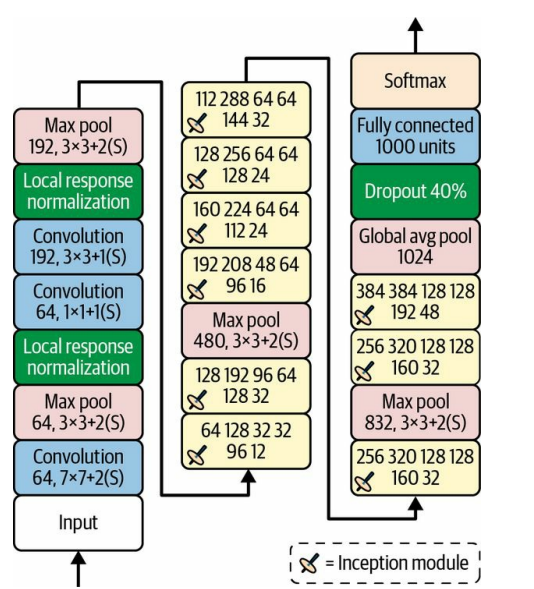

- Convolutional Layer + Max Pooling divide image's height and width by 4 (so its area is divided by 16), reducing computational load. A large $7\times7$ kernel is used at the begininng, preserving much of the information;
- LRN to increase variety of patterns captured by previous layers;
- 2 Convolutional Layers with first acting as Bottleneck Layer;
- LRN to increase variety of patterns captured by previous layers;
- Max Pooling to reduce height and width by 2, reducing computational load;
- 9 Inception Modules (with some Max Pooling layers to reduce computational load);
- Global Average Pooling to output mean of each feature map (this drops any remaining spatial information, which at this point is not that much; moreover, being this a classification task and not a localization one, this dimensionality reduction brought by this layer won't remove any important information and will instead decrease the number of needed fully connected layers at the top of CNN, reducing the number of parameters and overfitting risk);
- last layers are self-explanatory: droput for regolarization, fully connected layer with 1000 units (there are 1000 classes), softmax to get probabilities.

(Inception-v3 and Inception-v4 are variants of GoogLeNet)

### VGGNet
The [VGGNet](https://arxiv.org/abs/1409.1556), developed by Simonyan and Zisserman, classified 2nd in the ILSVRC 2014 with a very **simple and classical** architecture: 2 or convolutional layers and a pooling layer, repeated a series of times, plus a final 2 hidden layers dense network; it used a lot of small $3\times3$ kernels.

### ResNet (Residual Network)
The [ResNet](https://arxiv.org/abs/1512.03385) won the ISLVRC 2015 with a top-five error rate under 3.6%. It used an **extremely deep CNN** (152 layers), confirming the trend of Computer Vision models to become deeper and deeper with fewer and fewer parameters. 

This network was trained using the so called **Residual Learning**: generally, training a NN means to model a target function $h(x)$; with Residual Learning, the goal becomes to model $f(x) = h(x) - x$. This step of adding the input of a layer to the output of a layer located higher up the stack is called **Skip Connection** (also called **Shortcut Connection**).

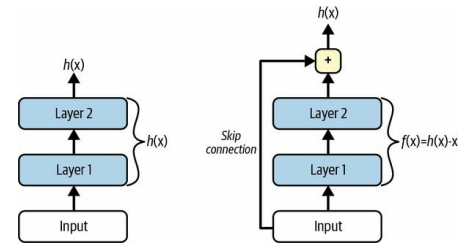

The idea behind this technique is that when initialized, a regular NN has weights close to zero, so the outputs are close to 0 aswell; adding a skip connection take the just initialized NN to output a copy of its inputs (i.e., it initially models the Identity Function). If the target function is fairly close to the identity function (which is often the case), the training will be sped up considerably.

Moreover, adding many skip connections takes the network to start making progress even if several layers have not started learning yet (see below a regular NN on left and a residual NN on right):

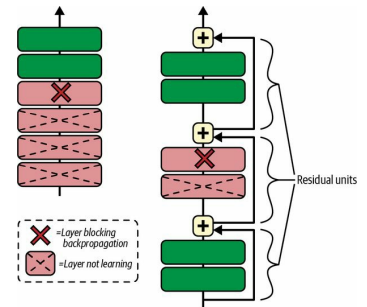

ResNet full architecture:

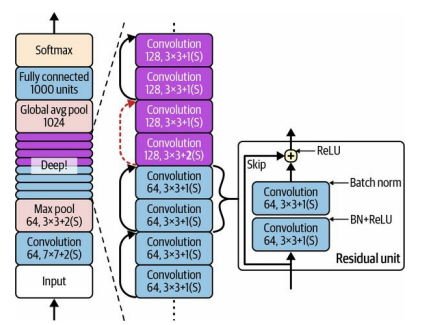

Note how the number of feature maps is doubled every few residual units, while at the same time height and width are halved (using convolutional layer with stride 2); because of this, we can't simply add inputs to the outputs (residual learning), because they have different shape: to solve this, inputs are passed through a $1\times1$ convolutional layer;

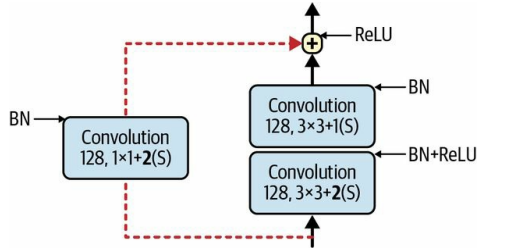

(Google's Inception-v4 merged the ideas of GoogLeNet and ResNet reaching a top-five error rate close to 3% on ImageNet classification)

### Xception (Extreme Inception)
The [Xception](https://arxiv.org/abs/1610.02357) is a variant of GoogLeNet proposed in 2016 by Francois Chollet (author of Keras); just like Inception-v4, it merges the ideas of GoogLeNet and ResNet, but it replaces the Inception Module with a special layer called **Depthwise Separable Convolution Layer** (or **Separable Convolution Layer** in short): while regular convolutional layer uses filters trying to simultaneously capture spatial patterns (e.g., an oval) and cross-channel patterns (e.g., mouth + nose + eyes = face), this new special layer makes the strong assumption than spatial patterns and cross-channel patterns can be modeled separately.

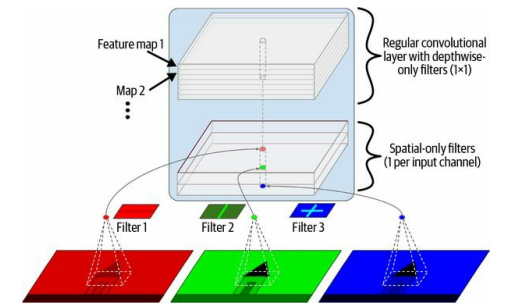

Following this assumption, it is made of 2 parts:
- first part applies a single spatial filter to each input feature map;
- second part is a regular convolutional layer with 1x1 filters which looks exclusively for cross-channel patterns.

So, we can think of an inception module (it only looks for cross-channel patterns) as an intermediate between a regular convolutional layer (it joins spatial and cross-channel patterns) and a separable convolutional layer (it splits spatial and cross-channel patterns).

In practice, separable convolution layer use fewer parameters, less memory and fewer computations than regular convolutional layer, and they generally perform better, so consider using them by default (considering they use one spatial filter per input channels, it is not suggested to use these separable layers after layers with too few channels, such as the input layer).

In Keras, just use SeparableConv2D instead of Conv2D.

The full architecture of Xception is made of 2 regular convolutional layer at the beginning (as suggested, separable ones are not well-suited after the input layer) and 34 separable convolution layers, with few max pooling layers and the usual final layers (global average pooling and dense layer).

### SENet (Squeeze-and-Excitation Network)
The [SENet](https://arxiv.org/abs/1709.01507) won the ILSVRC 2017 by reaching a 2.25% top-five error rate. This was reached by extending existing architectures such as inception networks (creating the SE-Inception) and the ResNet (creating the SE-ResNet), boosting their performance by adding a small neural network, called the **SE block** to every inception module/residual unit in the original architecture:

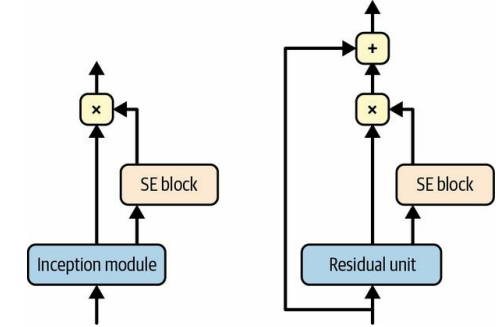

An SE block analyzes the output of the unit it is attached to, focusing only on depth dimension (so cross-channel patterns and not spatial patterns), learning which features are usually most active together. It then uses this information to recalibrate the feature maps; for example, an SE block may learn that mouths, noses and eyes usually appear together in pictures, so when you see a mouth and a nose, you should expect to see eyes as well. Given that, if the block sees strong activation in the mouth and nose feature maps, while a mild one in the eye feature map, it will boost this last one (or, more accurately, it will reduce irrelevant feature maps). This generally solves the case in which eyes were somewhat confused with something else.

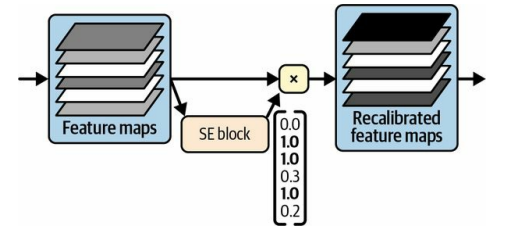

The composition of an SE block is made of 3 layers:
- a global average pooling layer;
- an hidden dense layer with ReLU: it is the responsible of the "squeeze", by significantly shrinking the number of feature maps (generally by 16 times), obtaining a low-dimensional vector representation (i.e., an **embedding**), forcing to learn a general representation of the feature combinations (this principle is at the base of autoencoders, Chapter 17 of this book);
- a dense output layer with sigmoid: it takes the embedding and outputs a recalibration vector containing one number per feature map, each between 0 and 1; the feature maps are then multiplied by this recalibration vector, taking irrelevant features to get scaled down.

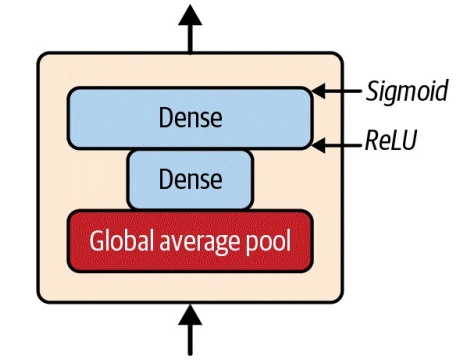

### Other Architectures
The next architectures will be discussed briefly:

#### ResNeXt
The [ResNeXt](https://arxiv.org/abs/1611.05431) improves the ResNet's residual units: while each original residual unit had 3 convolutional layer, in this version each residual unit is composed of many parallel stacks (e.g., 32 stacks), with 3 convolutional layer each. However, the first 2 layers in each stack use a few filters (e.g., 4 filters), so the overall number of parameters remain the same as ResNet.

#### DenseNet
The [DenseNet](https://arxiv.org/abs/1608.06993) is composed of several dense blocks, each made of few **Densely Connected convolutional layer** (i.e., the output of each layer is fed as input to every layer after it within the same block). This architecture achieved excellent accuracy using comparatively few parameters.

#### MobileNet
The [MobileNet](https://arxiv.org/abs/1704.04861) is one of a series of MobileNets, which are streamlined models designed to be lightweight and fast, making them popular in **mobile and web applications**. They are based on depthwise separable convolutional layer.

#### CSPNet (Cross Stage Partial Net)
The [CSPNet](https://arxiv.org/abs/1911.11929) is similar to DenseNet, but part of each dense block's input is concatenated directly to that block's output, without going through the block.

#### EfficientNet
The [EfficientNet](https://arxiv.org/abs/1905.11946) is the most important model in this list. Authors proposed a method to **scale any CNN** efficiently, called **Compound Scaling**: it is performed by jointly increasing the depth (number of layers), width (number of filters per layer) and resolution (size of the input image). They use **neural architecture search** to find a good architecture for a scaled-down versione of ImageNet and then perform compound scaling. When these model came out, they vastly outperformed all existing models and they remain among the best models out there today.

**Compound Scaling**:

It is based on a **logarithmic measure** of the **compute budget**, noted as **$\phi$**: if we double our computer budget, then $\phi$ increases by 1 (in other words, the **number of floating-point operations** available for training is **proportional to $2^{\phi}$**). Our CNN architecture's depth, width and resolutions should scale respectively of $\alpha^\phi, \beta^\phi, \gamma^\phi$, where each factor $\alpha, \beta, \gamma$ is greater than 1 and $\alpha + \beta^2 + \gamma^2$ should be close to 2 (optimal values for these factors depend on the CNN architecture). 

To find the optimal values of the EfficientNet, authors started working on the EfficientNetB0 with $\phi = 1$ and then ran a grid search, finding $\alpha = 1.2, \beta = 1.1, \gamma = 1.1$; they then created several larger architectures (named from EfficientNetB1 to EfficientNetB7), increasing $\phi$.

## Choosing the Right CNN Architecture

We have seen so many architectures but: how do we choose the best one for our project? There are different major goals we may have, such as:
- accuracy;
- model size (e.g., we want to deploy it to a mobile device);
- inference speed on CPU/GPU.

We will report a table with the best pre-trained architectures currently available on Keras, with some of their characteristics:

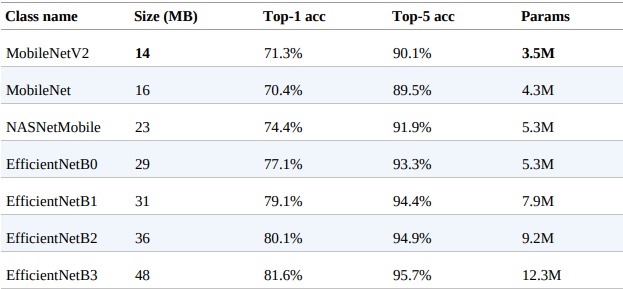
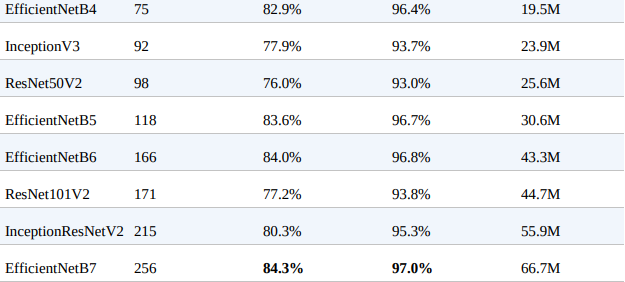

## Implementing a ResNet-34 from scratch using Keras

Most of the described CNN architectures can be implemented pretty naturally using Keras, altough you would generally load the pretrained network instead.

Let's implement a ResNet-34 from scratch using Keras; let's first create a ResidualUnit layer:

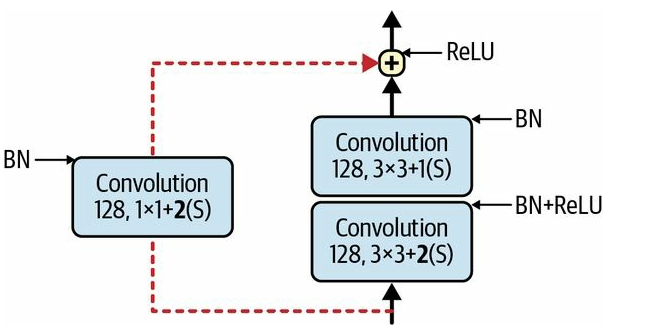


In [8]:
'''Visual Flow:
inputs ──┬─→ Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm ─→ Z
         │                                                      │
         └─→ [optional 1x1 conv if strides>1] ─────────→ skip_Z │
                                                                │
                                            ReLU(Z + skip_Z) ←──┘'''
                                            
from functools import partial                                        
                                            
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size = 3, strides = 1, padding = 'same', kernel_initializer = 'he_normal', use_bias = False)     # just a standard convolutional layer template

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides = 1, activation = 'relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)  # stores activation
        # creating the main computational path (right one above)
        self.main_layers = [    
            DefaultConv2D(filters, strides = strides),  # first convolutional layer
            tf.keras.layers.BatchNormalization(),   # normalize activations
            self.activation,    # activation (ReLU)
            DefaultConv2D(filters),  # second convolutional layer
            tf.keras.layers.BatchNormalization()    # final normalization         
        ]
        
        # creating the skip connection path (left one above)
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [    
                DefaultConv2D(filters, kernel_size = 1, strides = strides), # convolutional layer (with 1x1 kernel)
                tf.keras.layers.BatchNormalization()    # normalize activations
            ]
          
    # defining the forward pass
    def call(self, inputs):   
        # main computational path
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
            
        # skip connection (if any)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
            
        # residual learning
        return self.activation(Z + skip_Z)

We can now implement the full ResNet-34 architecture:

In [ ]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size = 7, strides = 2, input_shape = [224, 224, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size = 3, strides = 2, padding = 'same'),
])

# implementing the Residual Units
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides = strides))
    prev_filters = filters
    
model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))

C:\Users\39388\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


As we see, we built a model using a Sequential model and the trickier part is just the for loop implementing the residual units: as explained earlier, the first 3 RUs have 64 filters, the next 4 have 128 filters, and so on. 

At each iteration, if the number of filter matches the number of filters of the previous RU, then we don't need stride (stride = 1), else we need stride (stride = 2); we add the unit and we update the previous filters number.

In about 40 lines of code we implemented the model which won the ILSVRC 2015, showing the expressiveness of the Keras API.

## Using a Pretrained Model from Keras

We can easily load a ResNet-50 model pretrained on ImageNet with 1 line of code:

In [14]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step


Let's try to use it (we first need to resize some sampling images to a resolution of 224 x 224):

In [15]:
images = load_sample_images()["images"]
images_resized = tf.keras.layers.Resizing(height=224, width=224,crop_to_aspect_ratio=True)(images)

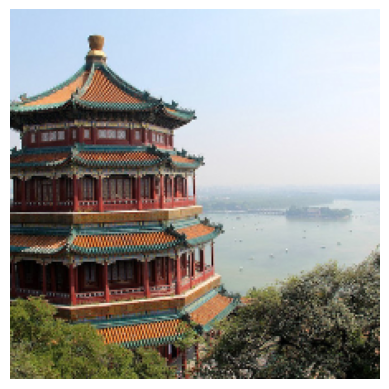

In [16]:
import matplotlib.pyplot as plt

plt.imshow(images_resized[0])
plt.axis('off')
plt.show()

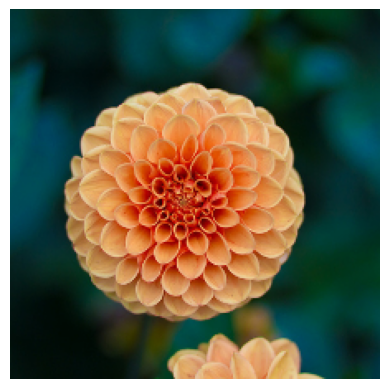

In [37]:
plt.imshow(images_resized[1])
plt.axis('off')
plt.show()

Each pretrained model assumes the images have been preprocessed in a specific way (maybe expect inputs from 0 to 1, or -1 to 1, and so on); luckily, each model also provides a preprocess_input() method we can use (these functions assume the original pixel values range from 0 to 255, as in our case):

In [17]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

We now use our model to make predictions:

In [18]:
Y_proba = model.predict(inputs)
Y_proba.shape

2025-07-30 17:37:39.337558: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=0} for conv %cudnn-conv-bias-activation.172 = (f32[2,128,28,28]{3,2,1,0}, u8[0]{0}) custom-call(f32[2,128,28,28]{3,2,1,0} %bitcast.4903, f32[128,128,3,3]{3,2,1,0} %bitcast.4910, f32[128]{0} %bitcast.4912), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", metadata={op_type="Conv2D" op_name="resnet50_1/conv3_block1_2_conv_1/convolution" source_file="/home/essskevin/tf-env/lib/python3.12/site-packages/tensorflow/python/framework/ops.py" source_line=1200}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false}
2025-07-30 17:37:41.695637: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algori

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


(2, 1000)

As usual, the output is a matrix with:
- one row per image (2 in this case);
- one columns per class (1000 in this case).

We can display the top K predictions, including class name, estimated probability of each predicted class with the decode_predictions() function:

In [19]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
for class_id, name, y_proba in top_K[image_index]:
    print(f" {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Image #0
Image #1
 n04209133 - shower_cap   34.37%
 n09229709 - bubble       11.41%
 n02782093 - balloon      9.46%


As we can see, ImageNet has 1000 classes, but they may not include the class we would like to classify our image.

What if we want to use an image classifier for classes of images not part of ImageNet?

Let's introduce **Transfer Learning**:

## Pretrained Models for Transfer Learning
**Transfer Learning** is performed when we want to build an image classifier, but we don't have enough data to train it from scratch: what we do is to reuse the lower layers of a pretrained model; let's look to an example by training a model to classify pictures of flowers, reusing a pretrained Xception model:

Loading the dataset:

In [7]:
import tensorflow_datasets as tfds

dataset, info = tfds.load('tf_flowers', as_supervised = True, with_info = True)
dataset_size = info.splits['train'].num_examples #3670
class_names = info.features['label'].names # ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
n_classes = info.features['label'].num_classes #5

/home/essskevin/tf-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 100%|██████████| 1/1 [01:07<00:00, 67.14s/ url]
                                                                        

Dataset tf_flowers downloaded and prepared to /home/essskevin/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


(NOTE: with_info = True gives us information about the dataset, like the size, name of classes, and so on)

Unfortunately, there is only a 'train' dataset, with no test nor validation set, so we need to split; we'll recall the tfds.load(), but this time with the split parameter to get 10% for testing, 15% for validation and 75% for training:

In [8]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    'tf_flowers',
    split = ['train[:10%]', 'train[10%:25%]', 'train[25%:]'],
    as_supervised = True
)

All 3 datasets contain individual images, so we may want to batch them in a tensor for efficient processing; to do so, we first must ensure same size, or batching will fail (we will use resize and then preprocess_input); we'll then shuffle the training set and use prefetching: 

In [9]:
batch_size = 32

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height = 224, width = 224, crop_to_aspect_ratio = True), # Resize
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input), # Preprocess
])

train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed = 42).batch(batch_size).prefetch(1)

valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

Each batch now contains 32 images, with 224x224 pixels, having pixel values from -1 to 1.

Since dataset is not very large, a bit of data augmentation may help; let's implement a data augmentation model which randomly flip images horizontally, rotate them a little bit and tweak the contrast:

In [10]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode = 'horizontal', seed = 42),
    tf.keras.layers.RandomRotation(factor = 0.05, seed = 42),
    tf.keras.layers.RandomContrast(factor = 0.2, seed = 42)
])

(NOTE: another approach is to use tf.keras.preprocessing.image.ImageDataGenerator class, which make it easy to load images from disk and augment them in various ways, making it a well suited solution for simple projects; however, including preprocessing and data augmentation as layers in the model, as we did, may benefit from GPU acceleration during training and it is not that harder to implement)

We now load a Xception model, pretrained on ImageNet. We easily exclude the top of the network (i.e., the global average pooling layer ans the dense output layer) setting include_top = False. We then add our own global average pooling layer (feeding it the output of the base model), followed by a dense output layer with one unit per class, using softmax:

In [11]:
base_model = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top = False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation = 'softmax')(avg)
model = tf.keras.Model(inputs = base_model.input, outputs = output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


As explained in Chapter 11 of this book, it's usually a good idea to freeze the weights of pretrained layers, at least at the beginning of training:

In [12]:
for layer in base_model.layers:
    layer.trainable = False

(NOTE how we use layer.trainable = False and not base_model.trainable = False)

We can finally compile the model and start training:

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.9)
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
history = model.fit(train_set, validation_data = valid_set, epochs = 3)

Epoch 1/3


2025-07-30 17:14:14.957621: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-07-30 17:14:18.070948: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:14:18.927794: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.34GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:14:19.955286: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.50GiB with freed_by_count=0. T

86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7052 - loss: 1.0036

2025-07-30 17:14:39.341335: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.16GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:14:39.640457: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-07-30 17:14:39.948200: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.35GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


86/86 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step - accuracy: 0.7998 - loss: 0.8295 - val_accuracy: 0.8475 - val_loss: 0.7187
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.9008 - loss: 0.3904 - val_accuracy: 0.8475 - val_loss: 0.6497
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 173ms/step - accuracy: 0.9451 - loss: 0.1808 - val_accuracy: 0.8475 - val_loss: 0.6575
